# Specifying a Custom Anchor Picker
In this notebook we show how to write your own anchor picker class, and demonstrate the effect different anchor pickers can have on the resulting approximate nearest neighbor graph.

In [14]:
# import some useful packages
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from annchor import Annchor, BruteForce,compare_neighbor_graphs
from tqdm.auto import tqdm as tq



In [2]:
# Specify some ANNchor params that we will keep constant
n_anchors = 10
p_work = 0.05

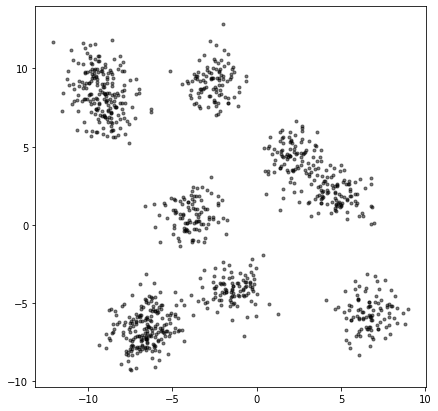

In [3]:
# Create and visualise a test data set
X,y,centers = make_blobs(centers=10,n_samples=1000,random_state=42,return_centers=True)

fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(X[:,0],X[:,1],marker='.',c='k',alpha=0.5)
#ax.scatter(centers[:,0],centers[:,1],marker='o',c='r',s=50)
plt.show()

In [4]:
# define our metric (just euclidean distance) and get exact k-NN graph
@njit()
def d(x,y):
    return np.linalg.norm(x-y)

bruteforce = BruteForce(X,d)
bruteforce.fit()

In [5]:
# Run Annchor with default anchor picker (maxmin) and determine its accuracy
annchor = Annchor(X,d,
                  n_anchors=n_anchors,
                  p_work=p_work)
annchor.fit()
n_errors = compare_neighbor_graphs(bruteforce.neighbor_graph,annchor.neighbor_graph,n_neighbors=15)
print('# errors (maxmin) = %d' % n_errors)

# errors (maxmin) = 11


In [7]:
# Here we create an anchor picker class which uses a set of pre-chosen points in R2.

class ExternalAnchorPicker:
    def __init__(self,A):
        # Initialise our anchor picker
        self.A=A  # Init our class with the list of pre-chosen points (A)
        self.is_anchor_safe=False # If your anchors do not come from the set X
                                  # then is_anchor_safe should be False

    def get_anchors(self, ann: 'Annchor'):
        # This is the main bulk of the class.
        # get_anchors should find the anchor points, and work out the distances to
        # each point in the data set.
        
        # define some shorthand variables
        nx = ann.nx
        na = ann.n_anchors
        
        # set random seed for reproducability
        np.random.seed(ann.random_seed) 

        # D stores distances to anchor points
        # note: at this point D is shape (n_anchors, nx),
        #       but we transpose this after calculations.
        D = np.zeros((na, nx)) + np.infty

        # This bit wraps our loop in tqdm for progress bars if we choose to be 'verbose'
        if ann.verbose:
            v = lambda f:tq(f)
        else:
            v = lambda f:f
        
        # loop over our data set and calculate distance to anchor points
        for i in v(range(na)):
            
            D[i] = np.array([ann.f(x,self.A[i]) for x in ann.X])
            
        # Returns 3-tuple (A,D,n_evals)
        # A = array of indices of anchor points if they are in our data set, otherwise empty array
        # D = array of distances to anchor points
        # n_evals = number of calls to the metric
        return np.array([]), D.T, na*nx

In [9]:
# Let's pick a ring of points surrounding our data and use those as the anchors
theta = np.linspace(0,np.pi*2,11)[:-1]
ring = np.vstack([15*np.cos(theta),15*np.sin(theta)]).T


ring_anchor_picker = ExternalAnchorPicker(ring)
annchor_ring = Annchor(X,d,
                       n_anchors=n_anchors,
                       anchor_picker=ring_anchor_picker,
                       p_work=p_work)
annchor_ring.fit()
n_errors = compare_neighbor_graphs(bruteforce.neighbor_graph,
                                   annchor_ring.neighbor_graph,
                                   n_neighbors=15)
print('# errors (ring) = %d' % n_errors)

# errors (ring) = 0


In [11]:
# Now let's try picking the centers of our data clusters and using those as the anchors
center_anchor_picker = ExternalAnchorPicker(centers)
annchor_center = Annchor(X,d,
                         n_anchors=n_anchors,
                         anchor_picker=center_anchor_picker,
                         p_work=p_work)
annchor_center.fit()
n_errors = compare_neighbor_graphs(bruteforce.neighbor_graph,
                                   annchor_center.neighbor_graph,
                                   n_neighbors=15)
print('# errors (centers) = %d' % n_errors)

# errors (centers) = 32


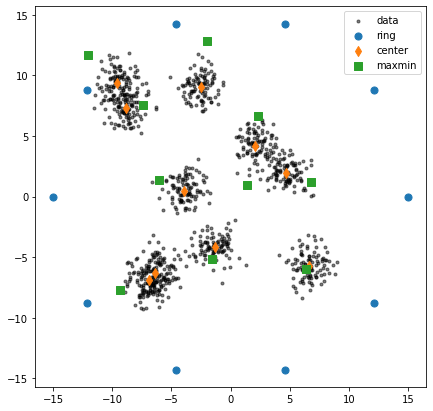

In [12]:
# Quickly visualise the difference in locations of our anchor points
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(X[:,0],X[:,1],marker='.',c='k',alpha=0.5,label='data')
ax.scatter(ring[:,0],ring[:,1],marker='o',s=50,label='ring')
ax.scatter(centers[:,0],centers[:,1],marker='d',s=50,label='center')
ax.scatter(X[annchor.A][:,0],X[annchor.A][:,1],marker='s',s=50,label='maxmin')
ax.legend()
plt.show()

In [15]:
# Let's do a bunch of runs to see how everything averages out over the random
# this could take a while - go grab a cup of tea (or lower n_runs...)

n_runs = 100

def test(anchor_picker, seed,p_work=0.1):
    ann = Annchor(X,d,
                 n_anchors=n_anchors,
                 anchor_picker=anchor_picker,
                 p_work=p_work,
                 random_seed=seed)
    ann.fit()
    return compare_neighbor_graphs(bruteforce.neighbor_graph,
                                   ann.neighbor_graph,
                                   n_neighbors=15)
from annchor.pickers import MaxMinAnchorPicker
cs = [test(ExternalAnchorPicker(centers),i,p_work=0.05) for i in tq(range(n_runs))]
rs = [test(ExternalAnchorPicker(ring),i,p_work=0.05) for i in tq(range(n_runs))]
ms = [test(MaxMinAnchorPicker(),i,p_work=0.05) for i in tq(range(n_runs))]



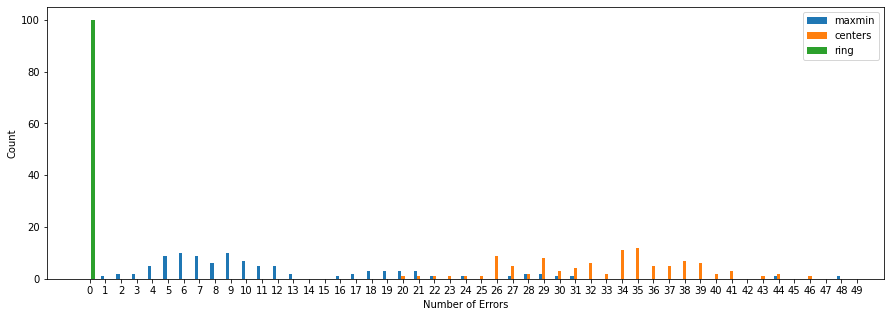

In [16]:
# Visualise the distribution of errors for the different anchor pickers

fig,ax = plt.subplots(figsize=(15,5))
ax.bar(np.arange(49)-0.2,np.histogram(ms,bins= np.arange(50))[0],width=0.2,label = 'maxmin')
ax.bar(np.arange(49),np.histogram(cs,bins= np.arange(50))[0],width=0.2,label = 'centers')

ax.bar(np.arange(49)+0.2,np.histogram(rs,bins= np.arange(50))[0],width=0.2,label = 'ring')

ax.legend()
ax.set_xticks(np.arange(50))
ax.set_ylabel('Count')
ax.set_xlabel('Number of Errors')
plt.show()

In [17]:
# It is worth noting that increasing p_work mitigates the choice of anchor picker

n_runs = 10

cs = [test(ExternalAnchorPicker(centers),i,p_work=0.1) for i in tq(range(n_runs))]
rs = [test(ExternalAnchorPicker(ring),i,p_work=0.1) for i in tq(range(n_runs))]
ms = [test(MaxMinAnchorPicker(),i,p_work=0.1) for i in tq(range(n_runs))]




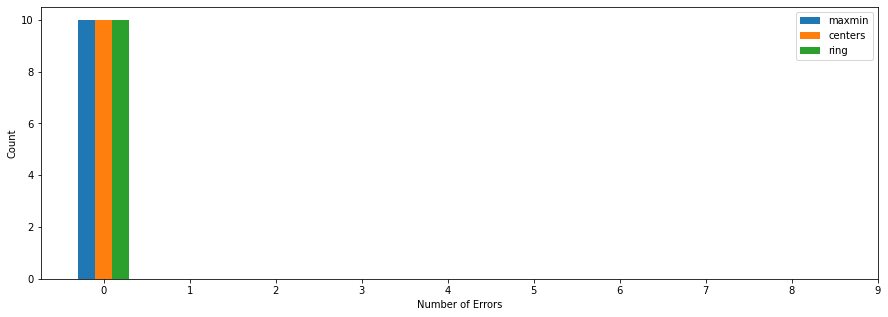

In [18]:
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(np.arange(9)-0.2,np.histogram(ms,bins= np.arange(10))[0],width=0.2,label = 'maxmin')
ax.bar(np.arange(9),np.histogram(cs,bins= np.arange(10))[0],width=0.2,label = 'centers')
ax.bar(np.arange(9)+0.2,np.histogram(rs,bins= np.arange(10))[0],width=0.2,label = 'ring')

ax.legend()
ax.set_xticks(np.arange(10))
ax.set_ylabel('Count')
ax.set_xlabel('Number of Errors')
plt.show()